# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [3]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The dataset is located [here](https://drive.google.com/file/d/1z1gYSD32ktbHuKSzB5JVS_u4YsLibh5F/view?usp=sharing), please download it and place it in the data folder.

In [9]:
# loading the data:

customers = pd.read_csv('../data/Wholesale_customer_data.csv')
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [10]:
# Your code here:

customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [11]:
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [12]:
corr = customers.corr()
corr

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,0.062028,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Region,0.062028,1.000000,0.055287,0.032288,0.007696,-0.021044,-0.001483,0.045212
Fresh,-0.169172,0.055287,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.032288,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,0.007696,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,-0.021044,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.001483,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.045212,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


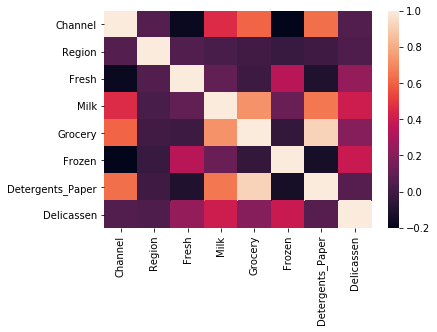

In [13]:
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns)

In [14]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


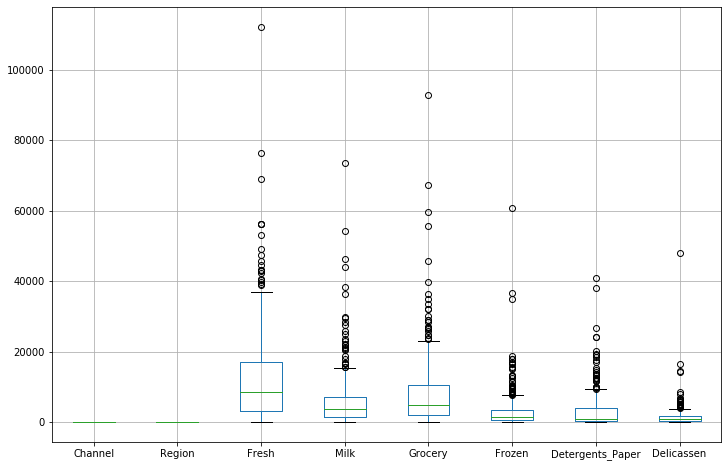

In [17]:
customers.boxplot(figsize = (12, 8))
#Paolo: I like this visualization

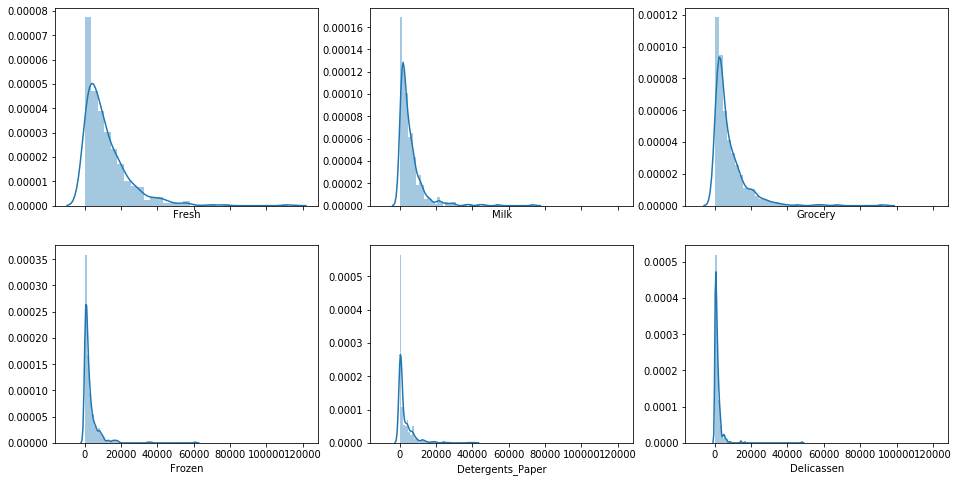

In [18]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
sns.distplot(customers['Fresh'], ax=axes[0, 0])
sns.distplot(customers['Milk'], ax=axes[0, 1])
sns.distplot(customers['Grocery'], ax=axes[0, 2])
sns.distplot(customers['Frozen'], ax=axes[1, 0])
sns.distplot(customers['Detergents_Paper'], ax=axes[1, 1])
sns.distplot(customers['Delicassen'], ax=axes[1, 2])


In [ ]:
# Your observations here

# The first two columns seem to be categorical columns ('Channel' only has values 1 and 2, 'Region' only 1,2 and 3)
# The other columns are types of groceries and should all be numerical columns, which they are
# There is no missing data
# Only two columns are highly correlated: 'Grocery' and 'Detergents_Paper' (r = 0,92), so one should be removed
# The distribution is positively skewed for all numerical variables, so possibly a square root, cube root, or log transformation could help here
# There are many outliers to the right, but this is probably the result of the skewness and they are probably valid data points. 
# I don't see reason to remove them
#Paolo: ok


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [19]:
# Your code here

# First, remove 'Detergents_Paper' columns as it's highly correlated with the 'Grocery' column

customers.drop(columns = 'Detergents_Paper', axis = 1, inplace = True)
customers.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen
0,2,3,12669,9656,7561,214,1338
1,2,3,7057,9810,9568,1762,1776
2,2,3,6353,8808,7684,2405,7844
3,1,3,13265,1196,4221,6404,1788
4,2,3,22615,5410,7198,3915,5185


In [49]:
# I'm going to approach data conversion in several ways as I see different possible options.
# I'll compare the models with the different conversion approaches to see which one works best

# The first two columns ('Channel' and 'Region') have numerical type but behave as categorical data (and according to data source are nominal data)
# So, I will test three versions: one with the columns as numerical data (as they are), one without these columns, and one with the one-hot encoded columns

# customers = version with all numerical columns
#Paolo:ok

In [50]:
# customers1 will be version with one-hot encoding for first two columsn
# convert data type from numerical to categorical for first two colums

customers1 = customers.copy()
customers1['Channel'] = customers1['Channel'].apply(str)
customers1['Region'] = customers1['Region'].apply(str)

In [51]:
customers1.dtypes

Channel          object
Region           object
Fresh             int64
Milk              int64
Grocery           int64
Frozen            int64
Delicassen        int64
labels            int32
labels_DBSCAN     int64
dtype: object

In [52]:
# one hot encode first two columns:

customers1_dummy = pd.get_dummies(customers1, columns = ['Channel', 'Region'])

In [53]:
customers1_dummy.dtypes

Fresh            int64
Milk             int64
Grocery          int64
Frozen           int64
Delicassen       int64
labels           int32
labels_DBSCAN    int64
Channel_1        uint8
Channel_2        uint8
Region_1         uint8
Region_2         uint8
Region_3         uint8
dtype: object

In [54]:
customers1_dummy.head()

,Fresh,Milk,Grocery,Frozen,Delicassen,labels,labels_DBSCAN,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,1338,4,0,0,1,0,0,1
1,7057,9810,9568,1762,1776,4,0,0,1,0,0,1
2,6353,8808,7684,2405,7844,4,-1,0,1,0,0,1
3,13265,1196,4221,6404,1788,0,2,1,0,0,0,1
4,22615,5410,7198,3915,5185,4,-1,0,1,0,0,1


In [55]:
# Create customers2 without the first two columns

customers2 = customers.drop(columns = ['Channel', 'Region'], axis = 1)

In [56]:
customers2.head()

,Fresh,Milk,Grocery,Frozen,Delicassen,labels,labels_DBSCAN
0,12669,9656,7561,214,1338,4,0
1,7057,9810,9568,1762,1776,4,0
2,6353,8808,7684,2405,7844,4,-1
3,13265,1196,4221,6404,1788,0,2
4,22615,5410,7198,3915,5185,4,-1


In [57]:
# For the customers2 version, I'm also going to try the effect of transforming the numerical variables so they're less skewed
# I'm trying three different transformations: log, square root and cube root

# Apply log conversion to remaining numerical columns

customers2_log = customers2.apply(lambda x: np.log10(x))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


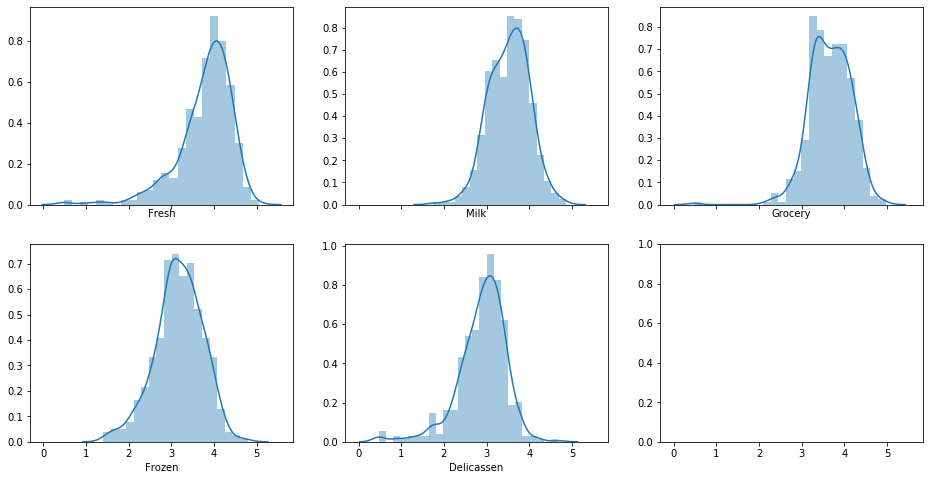

In [58]:
# visually check whether distribution improved

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
sns.distplot(customers2_log['Fresh'], ax=axes[0, 0])
sns.distplot(customers2_log['Milk'], ax=axes[0, 1])
sns.distplot(customers2_log['Grocery'], ax=axes[0, 2])
sns.distplot(customers2_log['Frozen'], ax=axes[1, 0])
sns.distplot(customers2_log['Delicassen'], ax=axes[1, 1])

In [29]:
# Apply square root conversion to numerical columns

customers2_sqrt = customers2.apply(lambda x: np.sqrt(x))

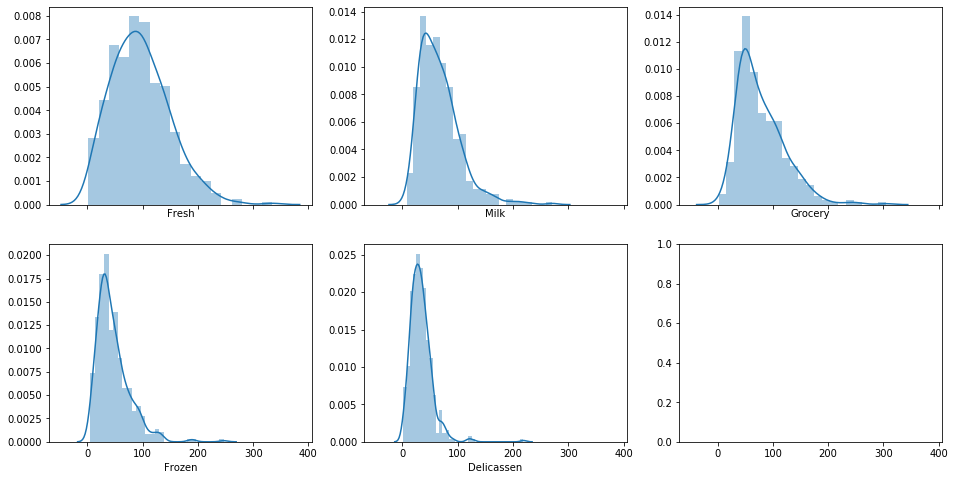

In [30]:
# visually check whether distribution improved

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
sns.distplot(customers2_sqrt['Fresh'], ax=axes[0, 0])
sns.distplot(customers2_sqrt['Milk'], ax=axes[0, 1])
sns.distplot(customers2_sqrt['Grocery'], ax=axes[0, 2])
sns.distplot(customers2_sqrt['Frozen'], ax=axes[1, 0])
sns.distplot(customers2_sqrt['Delicassen'], ax=axes[1, 1])

In [31]:
# Apply cube root conversion to numerical columns

customers2_cubrt = customers2.apply(lambda x: np.cbrt(x))

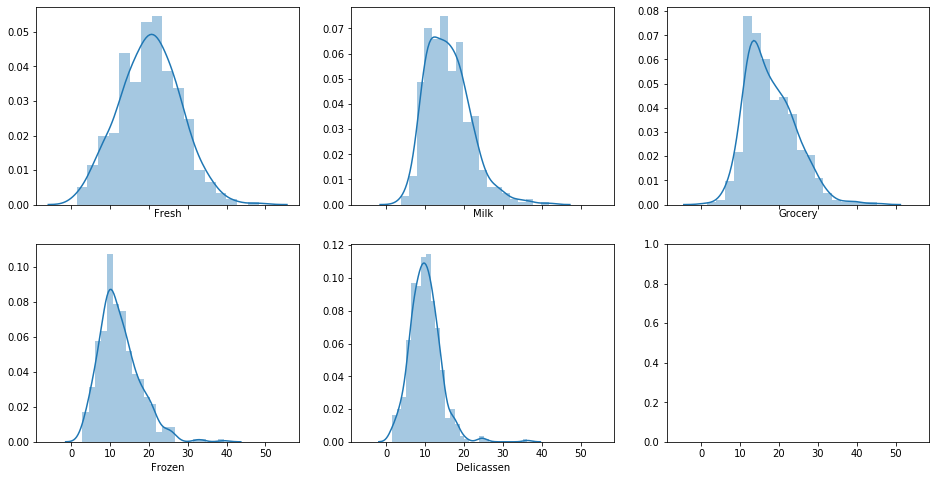

In [32]:
# visually check whether distribution improved

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
sns.distplot(customers2_cubrt['Fresh'], ax=axes[0, 0])
sns.distplot(customers2_cubrt['Milk'], ax=axes[0, 1])
sns.distplot(customers2_cubrt['Grocery'], ax=axes[0, 2])
sns.distplot(customers2_cubrt['Frozen'], ax=axes[1, 0])
sns.distplot(customers2_cubrt['Delicassen'], ax=axes[1, 1])

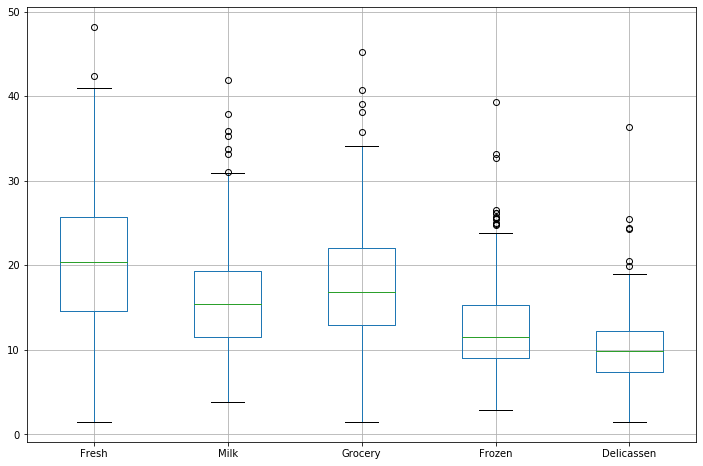

In [33]:
# The cuberoot transformation seems to best improve the skew of the data so I'll go forward with that one

# check outliers in the transformed data:

customers2_cubrt.boxplot(figsize = (12, 8))

# there are considerably fewer outliers than with the untransformed data
# not sure whether to remove them - as they seem to be valid data points and not errors I choose not to

In [34]:
# So now I have 4 versions of the data:
# customers: first two columns as numerical, data untransformed
# customers1_dummy: first two columns categorical one hot encoded
# customers2: first two columns dropped
# customers2_cubrt: variables transformed with cube root transformation to improve skewness
#Paolo:ok

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [59]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

scaler = StandardScaler()
customers_scale = scaler.fit_transform(customers)
customers_scale = pd.DataFrame(customers_scale)

In [60]:
customers_scale1 = scaler.fit_transform(customers1_dummy)
customers_scale1 = pd.DataFrame(customers_scale1)

In [61]:
customers_scale2 = scaler.fit_transform(customers2)
customers_scale2 = pd.DataFrame(customers_scale2)

In [62]:
customers_scale2_cubrt = scaler.fit_transform(customers2_cubrt)
customers_scale2_cubrt = pd.DataFrame(customers_scale2_cubrt)

In [ ]:
# Paolo: very thoughtful analysis. 
# Paolo: what about the pareto principle of the question?

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [63]:
# Your code here:

from sklearn.cluster import KMeans

customer_kmeans = KMeans().fit(customers_scale)
customers['labels'] = customer_kmeans.labels_

Count the values in `labels`.

In [64]:
# Your code here:

customers['labels'].value_counts()

1    174
0     94
6     50
4     43
3     37
5     36
7      5
2      1
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [65]:
# Your code here

from sklearn.cluster import DBSCAN

customers_dbscan = DBSCAN(eps=0.5).fit(customers_scale)

customers['labels_DBSCAN'] = customers_dbscan.labels_

Count the values in `labels_DBSCAN`.

In [66]:
# Your code here

customers['labels_DBSCAN'].value_counts()

-1    225
 2    135
 0     31
 4     23
 6      7
 5      7
 1      7
 3      5
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

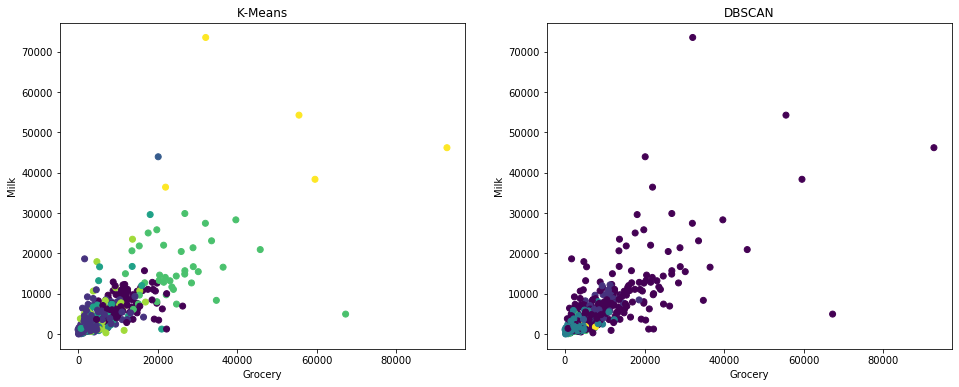

In [67]:
# Your code here:

# I removed 'Detergents_Paper' from the data as it was higly correlated with 'Grocery'
# I'll replace it here with 'Grocery'

fig, [ax1, ax2] = plt.subplots(1,2, figsize = (16,6))

ax1.scatter(x=customers['Grocery'], y=customers['Milk'], c=customers['labels'])
ax1.set_title('K-Means')
ax1.set_xlabel('Grocery')
ax1.set_ylabel('Milk')

ax2.scatter(x=customers['Grocery'], y=customers['Milk'], c=customers['labels_DBSCAN'])
ax2.set_title('DBSCAN')
ax2.set_xlabel('Grocery')
ax2.set_ylabel('Milk')

plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

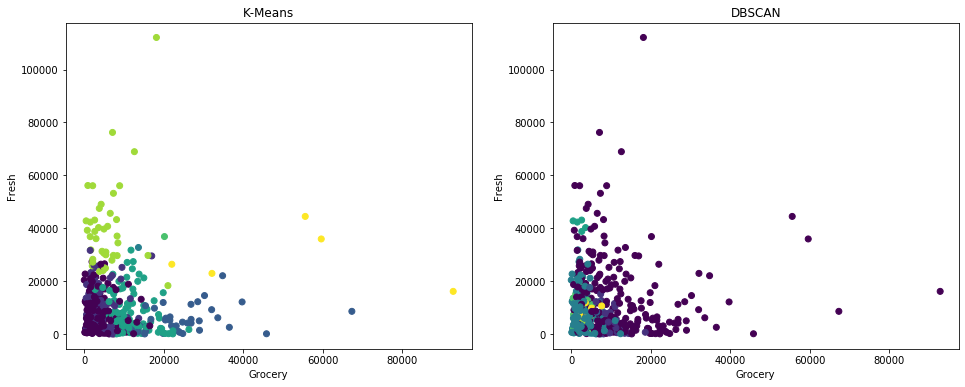

In [45]:
# Your code here:

fig, [ax1, ax2] = plt.subplots(1,2, figsize = (16,6))

ax1.scatter(x=customers['Grocery'], y=customers['Fresh'], c=customers['labels'])
ax1.set_title('K-Means')
ax1.set_xlabel('Grocery')
ax1.set_ylabel('Fresh')

ax2.scatter(x=customers['Grocery'], y=customers['Fresh'], c=customers['labels_DBSCAN'])
ax2.set_title('DBSCAN')
ax2.set_xlabel('Grocery')
ax2.set_ylabel('Fresh')

plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

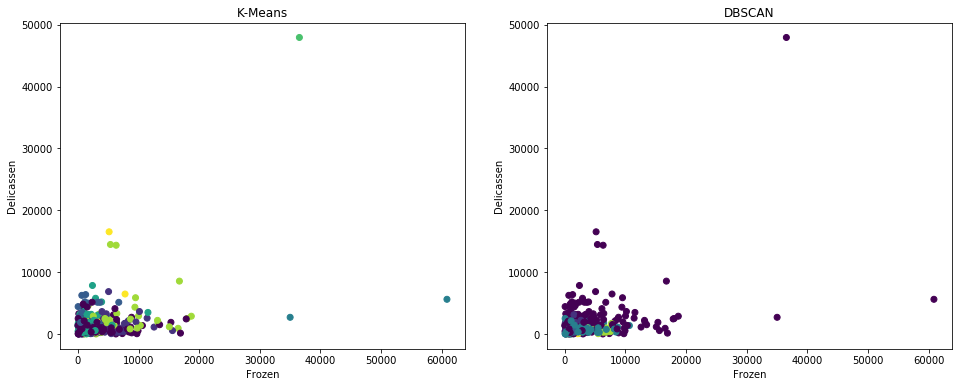

In [46]:
# Your code here:

fig, [ax1, ax2] = plt.subplots(1,2, figsize = (16,6))

ax1.scatter(x=customers['Frozen'], y=customers['Delicassen'], c=customers['labels'])
ax1.set_title('K-Means')
ax1.set_xlabel('Frozen')
ax1.set_ylabel('Delicassen')

ax2.scatter(x=customers['Frozen'], y=customers['Delicassen'], c=customers['labels_DBSCAN'])
ax2.set_title('DBSCAN')
ax2.set_xlabel('Frozen')
ax2.set_ylabel('Delicassen')

plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [47]:
# Your code here:

customers.groupby('labels').agg('mean')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,labels_DBSCAN
labels,,,,,,,,
0,1.000000,3.000000,8805.649425,2843.431034,3358.344828,2675.367816,983.109195,1.344828
1,1.068966,1.298851,10111.091954,3301.908046,4235.747126,3089.057471,1080.827586,1.367816
2,1.972222,2.111111,5539.805556,15953.166667,25578.666667,1623.222222,2194.111111,-1.000000
3,1.000000,2.500000,22015.500000,9937.000000,7844.000000,47939.000000,4153.500000,-1.000000
4,2.000000,2.882979,8590.074468,7232.542553,11612.382979,1479.712766,1439.638298,-0.521277
5,1.000000,3.000000,36847.000000,43950.000000,20170.000000,36534.000000,47943.000000,-1.000000
6,1.048780,2.780488,39870.292683,4916.853659,5740.585366,6566.926829,2595.951220,-0.365854
7,2.000000,3.000000,29164.600000,49749.200000,52416.400000,3640.600000,5770.400000,-1.000000


In [48]:
customers.groupby('labels_DBSCAN').agg('mean')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen,labels
labels_DBSCAN,,,,,,,,
-1,1.468468,2.396396,14848.144144,8729.409910,11932.941441,4180.045045,2222.193694,2.684685
0,2.000000,3.000000,4580.290323,7785.032258,10442.096774,803.354839,1400.516129,4.000000
1,2.000000,3.000000,12530.857143,3213.000000,6117.857143,868.571429,350.857143,4.000000
2,1.000000,3.000000,8835.507246,2004.289855,2751.543478,2100.775362,740.869565,0.086957
3,1.000000,3.000000,41446.600000,1421.200000,2167.600000,1276.400000,784.800000,6.000000
4,1.000000,1.000000,9491.391304,1700.782609,2092.565217,1488.695652,648.782609,1.000000
5,1.000000,1.000000,7059.000000,1941.285714,2302.714286,6526.571429,667.000000,1.000000
6,1.000000,2.000000,8555.714286,1742.285714,4017.142857,2354.428571,855.571429,1.000000


Which algorithm appears to perform better?

In [ ]:
# Your observations here

# Perhaps I'm doing something wrong, but I really can't say which one performs better based on these figures or numbers, it's really unclear to me

# So I'm going to leave the comparison with the three other formatted datasets, because I can't really make sense of the first case

#Paolo: yes, it is not easy because it is an unsupervised problem we do not have a test set.
# However for example the dbscan has labelled a lot of data as (-1) which means that it   
# identifies many samples as noise, cannot cluster them properly. You could play with some
# of the parameters (eps, min_samples) to see what changes.
# See here https://scikit-learn.org/stable/modules/clustering.html#dbscan

# For Kmeans you could play with K and use the 'elbow method' to choose the optimal k. Have a look here 
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here